In [2]:
## import necessary modules
%matplotlib notebook

import os
import sys
import numpy as np
import pylab as plt
import pandas as pd

import joblib
import importlib

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.models.ecod import ECOD
from pyod.models.lof import LOF
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.cof import COF
from pyod.models.cd import CD
from pyod.models.copod import COPOD
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.inne import INNE
from pyod.models.kde import KDE
from pyod.models.loci import LOCI
from pyod.models.pca import PCA

from unsupervised_sort import unsupervised_runsort
importlib.reload(sys.modules['unsupervised_sort'])

<module 'unsupervised_sort' from '/home/ellie/research/lsst/lsst_seti/sycorax_search/unsupervised_sort.py'>

In [3]:
## load in the data, and establish some definitions
infile_name = '/home/ellie/research/lsst/LSST_sim.csv'
df_initial = pd.read_csv(infile_name)

## initialize name of file that the GMM is saved to
gmm_fname = "/home/ellie/research/lsst/gmm.pkl"

## set a value for the percentage of outliers, aka the contamination
## (This choice was arbitrary, should probably be tweaked)
contamination = 0.005

In [3]:
# select fields of interest
subspace = ["a*", "i-z", "a", "sini", "e", "v-vk", "r"]
df = df_initial[subspace]
df = df.dropna()

# normalize the data so that values fall in a range from 0-1
scaler = MinMaxScaler()
scaler.fit(df.to_numpy())
norm_data = scaler.fit_transform(df.to_numpy()) ## note "norm_data" is the same as X in Brian's code

#print(norm_data)
#print(norm_data[0])

In [4]:
## Load the previously-saved Gaussian mixture model:
gmm = joblib.load(gmm_fname)

# predict the labels for the data samples in X using the trained model 
#(need to understand this part better) -MEW
labels = gmm.predict(norm_data)

## add labels to the pandas dataframe as a new column -MEW
df["labels"] = labels

In [5]:
## split the data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(
    df[["a*", "i-z", "a", "sini", "e", "v-vk", "r"]], 
    df["labels"], #is it ok to use the labels determined by the GMM here? 
    test_size=.3,
    #random_state=42,
    stratify=df["labels"], #not sure this is right? 
    shuffle=True
)

#print(X_test)

In [10]:
## Try several algorithms...

clf_names = ['ABOD', 'CBLOF', 'CD', 'COPOD', 'FeatureBagging', 'HBOS', 'IForest', 'KNN', 'LOF']
clf_calls = [ABOD(), CBLOF(), CD(), COPOD(), FeatureBagging(), HBOS(), IForest(), KNN(), LOF()]

print(X_test)

for i in range(len(clf_names)):
    clf_name = clf_names[i]
    clf = clf_calls[i]
    
    df_sorted = unsupervised_runsort(clf, clf_name, X_test, X_train, df_initial)

    top_10 = df_sorted.head(10)
    
    print('*** Here are the results for {}***\n'.format(clf_name))
    print(top_10['ssObjectId'])
    print()
    print(X_test)

NameError: name 'X_test' is not defined

<IPython.core.display.Javascript object>


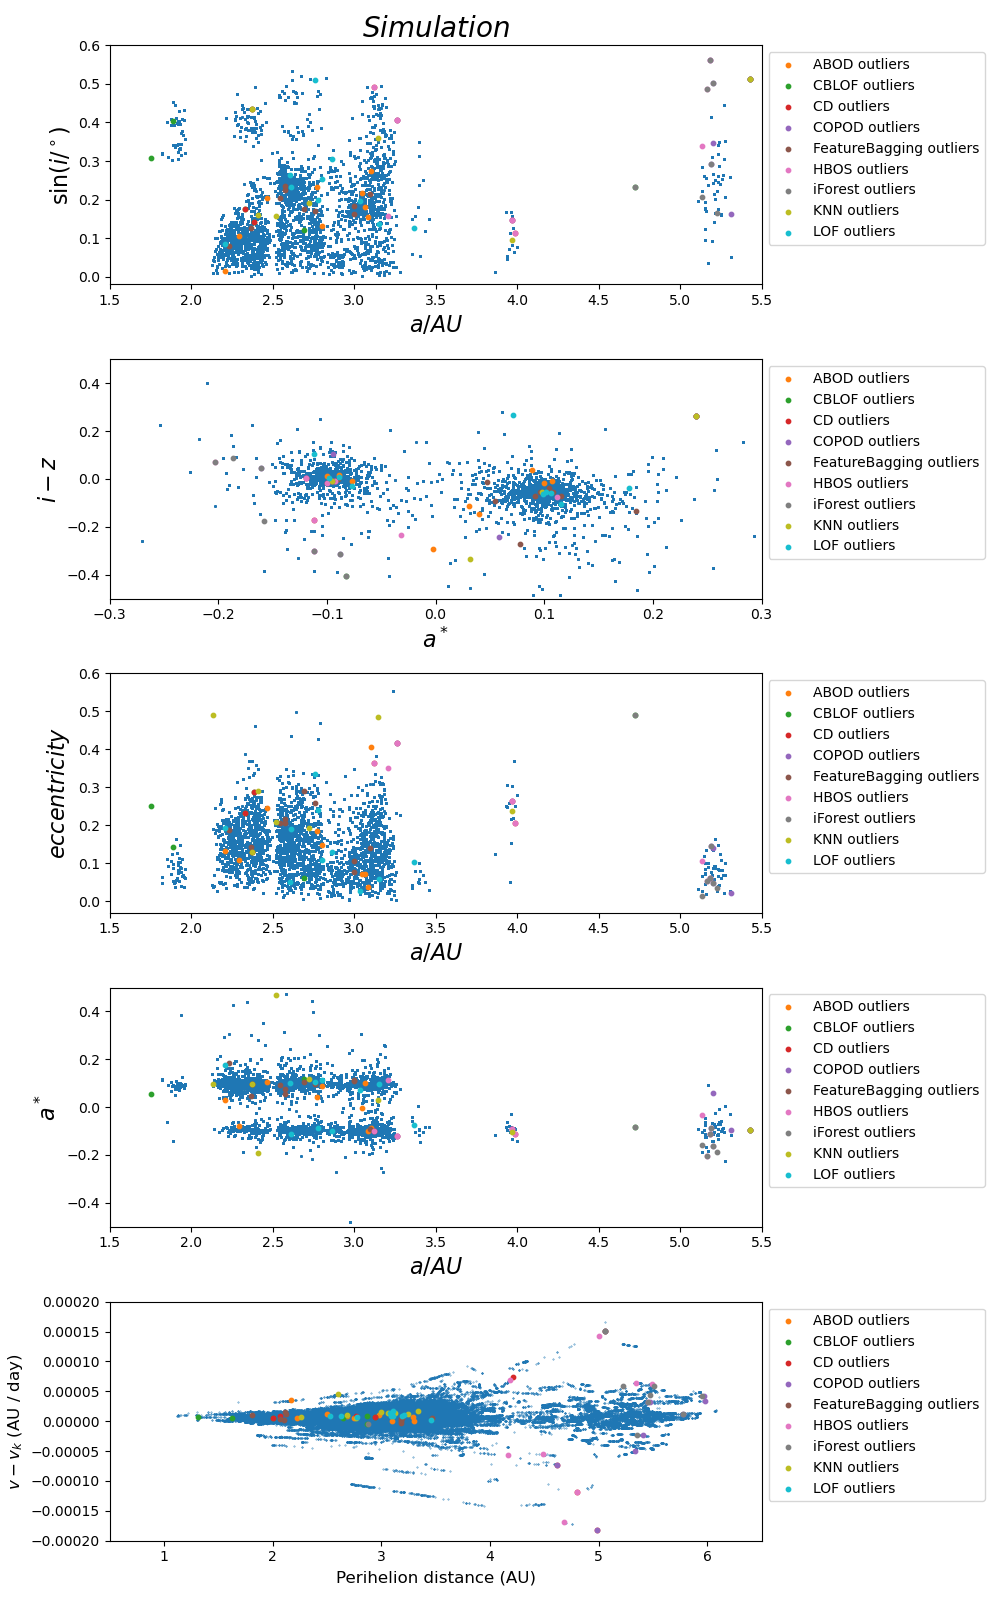

In [4]:
## this is just a quick way to plot the most outlying data points
## identified in the last step. Note there is some hardcoding here.
## Sorry :/

abod_outliers = [35467,263786,292916,24195,437790,326121,425189,431204,64738,462822]
cblof_outliers = [263786,319356,380531,9130,446173,199503,263537,241916,280304,358108]
cd_outliers = [263786,380531,9116, 319356,338644,446219,199503,428941,284712,131381]
copod_outliers = [263786,380531,199440,338644,284712,54094,427938,377490,353531,181007]
featurebagging_outliers = [472188,201149,492916,4719,171078,358419,50365,459272,215328,216926]
hbos_outliers = [380490,338681,131099,263783,168675,453579,284666,428949,228974,54174]
iforest_outliers = [380531,263789,453612,199440,54174,280310,377472,421374,427976,277648]
knn_outliers = [263786,380487,199459,63815,198391,202043,446173,65312,425239,387508]
lof_outliers = [48354,465581,159027,51136,169038,145213,13620,97856,17059,359759]

outlier_array = [abod_outliers, cblof_outliers, cd_outliers, copod_outliers, \
                 featurebagging_outliers, hbos_outliers, iforest_outliers, \
                 knn_outliers, lof_outliers]

algo_names = ['ABOD', 'CBLOF', 'CD', 'COPOD', 'FeatureBagging', 'HBOS', 'iForest', 'KNN', 'LOF']

df = df_initial

fig, axs = plt.subplots(5, 1, figsize=(10, 16))

#fig.suptitle("Comparison of simulation with the GMM reconstruction.")

axs[0].set_title(r"$Simulation$", fontsize=20)

## plot original "a" values vs "sini" values
## note s determines the size of the markers
## and alpha is transparency - MEW
axs[0].scatter(
    df["a"],
    df["sini"],
    s=0.1,
    alpha=1,
)

## set the x and y labels for the two "a" vs "sini" plots - MEW
axs[0].set_xlabel(r"$a / AU$", fontsize=16)
axs[0].set_ylabel(r"$\sin(i / ^\circ)$", fontsize=16)

'''axs[0][0].set_title("Simulation", fontsize=20)
axs[0][1].set_title("GMM reconstruction", fontsize=20)'''

## plot simulation "a*" vs "i-z" - MEW
axs[1].scatter(
    df["a*"],
    df["i-z"],
    s=0.1
)

## set x and y labels for the "a*" vs "i-z" plots - MEW
axs[1].set_xlabel(r"$a^*$", fontsize=16)
axs[1].set_ylabel(r"$i - z$", fontsize=16)

'''
axs[1][0].set_title("Simulation")
axs[1][1].set_title("GMM reconstruction")'''

## plot simulation "a" vs "e" - MEW
axs[2].scatter(
    df["a"],
    df["e"],
    s=0.1,
)

## set x and y axis labels for "a" vs "e" plots - MEW
axs[2].set_xlabel(r"$a / AU$", fontsize=16)
axs[2].set_ylabel(r"$eccentricity$", fontsize=16)

## plot simulation "a" vs "a*"
axs[3].scatter(
    df["a"],
    df["a*"],
    s=0.1,
)

## set x and y axis labels for "a" vs "a*" plots - MEW
axs[3].set_xlabel(r"$a / AU$", fontsize=16)
axs[3].set_ylabel(r"$a^*$", fontsize=16)

## plot simulation "v-vk" vs "r"
axs[4].scatter(
    df["r"],
    df["v-vk"],
    s=0.1,
)

## set x and y axis labels for "a" vs "a*" plots - MEW
axs[4].set_xlabel("Perihelion distance (AU)", fontsize=12)
axs[4].set_ylabel("$v - v_k$ (AU / day)", fontsize=12)

## set axis limits - MEW
axs[1].set_xlim(-.3, .3)
axs[1].set_ylim(-.5, .5)

axs[0].set_ylim(-0.02,.6)
axs[0].set_xlim(1.5,5.5)

axs[2].set_xlim(1.5,5.5)
axs[2].set_ylim(-.03, .6)

axs[3].set_xlim(1.5,5.5)
axs[3].set_ylim(-.5, .5)

axs[4].set_xlim(0.5,6.5)
axs[4].set_ylim(-.0002, .0002)


## plot the top ten outliers for each algorithm, defined above
for j in range(len(outlier_array)): 
    axs[0].scatter(
    df.loc[outlier_array[j]]["a"],
    df.loc[outlier_array[j]]["sini"],
    s=10,
    alpha=1,
    label='{} outliers'.format(algo_names[j]),
    )
    
    axs[1].scatter(
    df.loc[outlier_array[j]]["a*"],
    df.loc[outlier_array[j]]["i-z"],
    s=10,
    alpha=1,
    label='{} outliers'.format(algo_names[j]),
    ) 
    
    axs[2].scatter(
    df.loc[outlier_array[j]]["a"],
    df.loc[outlier_array[j]]["e"],
    s=10,
    alpha=1,
    label='{} outliers'.format(algo_names[j]),
    )
    
    axs[3].scatter(
    df.loc[outlier_array[j]]["a"],
    df.loc[outlier_array[j]]["a*"],
    s=10,
    alpha=1,
    label='{} outliers'.format(algo_names[j]),
    )
    
    axs[4].scatter(
    df.loc[outlier_array[j]]["r"],
    df.loc[outlier_array[j]]["v-vk"],
    s=10,
    alpha=1,
    label='{} outliers'.format(algo_names[j]),
    )
    
for k in range(5):
    axs[k].legend(loc='upper left', bbox_to_anchor=(1, 1))
    
## adjust padding and save the image - MEW
plt.tight_layout()
plt.savefig("plotted_outliers.png", dpi=600)

<IPython.core.display.Javascript object>


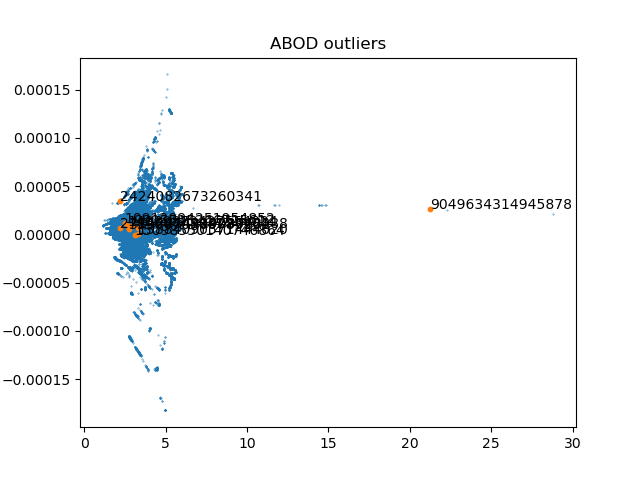

In [5]:
plt.close()

n = algo_names.index('ABOD')

plt.scatter(
    df["r"],
    df["v-vk"],
    s=0.1,
    )

plt.scatter(
    df.loc[outlier_array[n]]["r"],
    df.loc[outlier_array[n]]["v-vk"],
    s=10,
    alpha=1,
    )

plt.title('{} outliers'.format(algo_names[n]))

## add text labels here
for m in range(10):
    plt.text(df.loc[outlier_array[n][m]]["r"],df.loc[outlier_array[n][m]]["v-vk"], \
            '{}'.format(str(int(df.loc[outlier_array[n][m]]["ssObjectId"]))))
    
    '''for m in range(10):
    if df.loc[outlier_array[n][m]]["r"] < 6.5:
        plt.text(df.loc[outlier_array[n][m]]["r"],df.loc[outlier_array[n][m]]["v-vk"], \
                 '{}'.format(str(int(df.loc[outlier_array[n][m]]["ssObjectId"]))))'''

In [13]:
## Try K nearest neighbors (KNN) first...note this bit of code is 
## directly borrowed from https://pyod.readthedocs.io/en/latest/example.html

# train kNN detector
clf_name = 'KNN'
clf = KNN()
df_sorted = unsupervised_runsort(clf, clf_name, X_test, X_train, df_initial)

top_10 = df_sorted.head(10)
print(top_10['ssObjectId'])

263795     9049634314945878
199493     7158623547316216
380551    12524061909844359
63861      3503615432190265
206566     7341963806733616
198411     7116854030064750
202043     7226313263614204
9115       2026069171332162
466492    15192542398347107
425213    13885523847080451
Name: ssObjectId, dtype: int64


**Older code below, unmodularized**

Can be ignored at the moment...

In [36]:
## Try K nearest neighbors (KNN) first...note this bit of code is 
## directly borrowed from https://pyod.readthedocs.io/en/latest/example.html

# train kNN detector
clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_ # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_ # raw outlier scores
print(y_train_scores.shape)

(350000,)


In [22]:
# get the prediction on the test data
y_test_pred = clf.predict(X_test) # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test) # outlier scores
print(y_test_scores.shape)

# it is possible to get the prediction confidence as well
y_test_pred, y_test_pred_confidence = clf.predict(X_test, return_confidence=True) # outlier labels (0 or 1) and confidence in the range of [0,1]

(150000,)


In [27]:
X_test['KNN_score'] = y_test_scores

## sort the test samples from highest to lowest outlier scores
xtest_sorted = X_test.sort_values(by='KNN_score', ascending=False) 

## retrieve the indices of each sample, in a list where the indices are sorted from those
## corresponding to the sample with the highest outlier scores to the lowest 
indices = xtest_sorted.index.to_list() #retrieve indices of each sample

# get the sorted version of the dataframe with *all* of the fields, not just the subset fields
df_full_table_sorted = df_initial.loc[indices] 

#drop duplicate "observations" of same object
df_full_table_sorted = df_full_table_sorted.drop_duplicates(subset='ssObjectId', keep='first')

#select and print the top 10 most anomalous objects
top_10 = df_full_table_sorted.head(10)
print(top_10['ssObjectId'])

# print the log likelihood scores for the top 10 anomalies
top10_indices = top_10.index.to_list()
print(xtest_sorted.loc[top10_indices]['KNN_score'])

#print(df_full_table_sorted.loc[429524])

244226     8475518892800970
97400      4328331916809606
49360      3067700764313532
289136     9756175642120727
470925    15303595826525435
192792     6984198705492593
394225    12987813492034709
412502    13544133391651073
401782    13259977282123506
199987     7180167418787080
Name: ssObjectId, dtype: int64
244226    7.738920
97400     1.646173
49360     0.580370
289136    0.416227
470925    0.411339
192792    0.408095
394225    0.393991
412502    0.393177
401782    0.360276
199987    0.351284
Name: KNN_score, dtype: float64
